# Movie Recommendation System using Collaborative Filtering

Collaborative filtering approach builds a model from a user’s past behaviors (items previously purchased or selected and/or numerical ratings given to those items) as well as similar decisions made by other users. This model is then used to predict items (or ratings for items) that the user may have an interest in.
![alt text](https://thumbs.gfycat.com/ImperturbableAdvancedHorsefly-size_restricted.gif)

In [1]:
# Required Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

### Let's Talk a bit about Data.
__To build our Movie Recommendation System using the collaborative filtering approach we will be using [Movie Lens](https://grouplens.org/datasets/movielens/latest/) Dataset as it is regularly updated and coontains less noise.__
***
Few of the other dataset that can be used for this purpose are:-
- [Yahoo! - Movie, Music, and Images Ratings Data Sets](http://webscope.sandbox.yahoo.com/catalog.php?datatype=r)
- [Jester - Movie Ratings Data Sets (Collaborative Filtering Dataset)](http://www.ieor.berkeley.edu/~goldberg/jester-data/)
- [Cornell University - Movie-review data for use in sentiment-analysis experiments](http://www.cs.cornell.edu/people/pabo/movie-review-data/)
---
---
Data from the source comes in a .zip format so lets load the data and unzip it and extract files we need.
Files Required:-
1. movies.csv - movies dataset containing all related info.
2. ratings.csv - ratings dataset contains dataset ralted to ratings given to each movie in above dataset by different users.


In [2]:
movies_df = pd.read_csv('movies.csv', usecols=['movieId', 'title'],
                        dtype={'movieId': 'int32', 'title': 'str'})

ratings_df = pd.read_csv('ratings_dataset.csv', usecols=['userId', 'movieId', 'rating'],
                         dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
print('Movies Dataset Size: {} x {}'.format(movies_df.shape[0], movies_df.shape[1]))
print('Ratings Dataset Size: {} x {}'.format(ratings_df.shape[0], ratings_df.shape[1]))

Movies Dataset Size: 58098 x 2
Ratings Dataset Size: 1048575 x 3


In [4]:
ratings_df = pd.merge(movies_df, ratings_df)

In [5]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [6]:
ratings_df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),4,4.0
1,1,Toy Story (1995),10,5.0
2,1,Toy Story (1995),14,4.5
3,1,Toy Story (1995),15,4.0
4,1,Toy Story (1995),22,4.0


# Exploratory data analysis

1. __Plot the counts of each rating__
we first need to get the counts of each rating from ratings data

In [7]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(ratings_df.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,19099
1.0,33017
1.5,16660
2.0,70427
2.5,51076
3.0,209822
3.5,128663
4.0,278222
4.5,89672


In [8]:
num_users = len(ratings_df.userId.unique())
num_items = len(ratings_df.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 10532 unique users and 22156 unique movies in this data set


In [9]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings_df.shape[0]

# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()

df_ratings_cnt

,count
0.0,232298417
0.5,19099
1.0,33017
1.5,16660
2.0,70427
2.5,51076
3.0,209822
3.5,128663
4.0,278222
4.5,89672


In [10]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,232298417,19.263533
0.5,19099,9.857391
1.0,33017,10.404778
1.5,16660,9.720766
2.0,70427,11.162332
2.5,51076,10.841070
3.0,209822,12.254015
3.5,128663,11.764952
4.0,278222,12.536175
4.5,89672,11.403914


Text(0, 0.5, 'number of ratings')

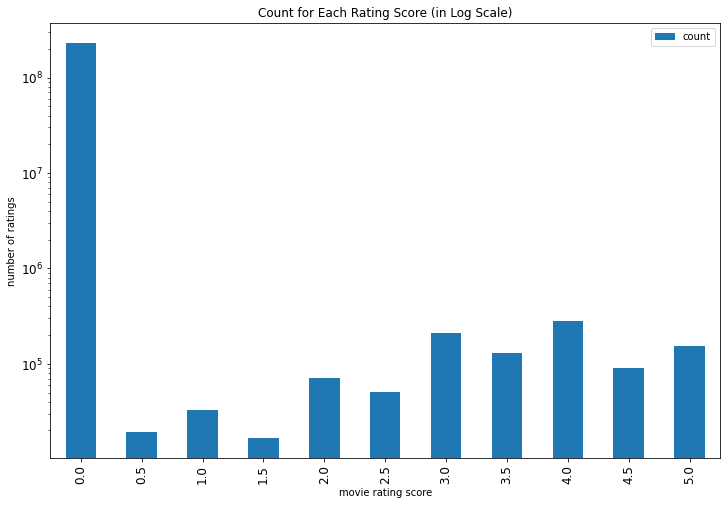

In [11]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

__It is worth noting that most of the users have given a voting of 3 or 4 then other ratings.__

---
---
---

>Here we have all data with us so lets start Building the model. Before building the model we might need to transform our data so that we can feed it ot our model. We will pivoting the data frame.

## Pivoting: -

I understand most of my readers might not know what is pivoting so lets discuss a litlle about pivoting.

- __Pivot Table__ : A pivot table is a table of statistics that summarizes the data of a more extensive table. This summary might include sums, averages, or other statistics, which the pivot table groups together in a meaningful way. Pivot tables are a technique in data processing. [source](https://en.wikipedia.org/wiki/Pivot_table)

![alt text](https://pandas.pydata.org/pandas-docs/stable/_images/reshaping_pivot.png)


Now Simple Definition for Pivoting:-

> __Pivoting a dataframe or a table can be viewed oor understood as transforming the dataframe i.e. replacing the row with the column info and vice versa.__ 

##### So now we know what is pivoting so lets get started !

In [12]:
user_ratings = ratings_df.pivot_table(index=['userId'],columns=['title'],values='rating')
user_ratings.head()

title,"""Great Performances"" Cats (1998)",#Horror (2015),#realityhigh (2017),$ (Dollars) (1971),$5 a Day (2008),$9.99 (2008),'71 (2014),'Hellboy': The Seeds of Creation (2004),"'Human' Factor, The (Human Factor, The) (1975)",'Pimpernel' Smith (1941),...,Мартынко (1987),Мафия (2016),Никто не знает про секс (2006),Обезьянки и грабители (1985),Он вам не Димон (2017),Оно (1990),Сердца трех (1992),Юленька (2009),Я худею (2018),チェブラーシカ (2010)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__So we see we got a lot of ```NAN```. This is because a single user cannot practically watch and rate all 22147 movies so we will eliminate all the user reviews who have voted only for 4 or less movies.__

>Running the above code might give errors such as :-
```sh
ValueError: Unstacked DataFrame is too big, causing int32 overflow
```

> To deal with thi error you will find either of the two solutions:-
- Shrink the size of input for ```.pivot()``` function.
- Downgrade the 'Pandas' version to 0.21 .
***
> Both of the solutions are good and solve the problem but which one will be easy and feasable. Most of us will think that instead of shrinking the data we will downgrade pandas version well it can be done but if you are using python version 3.8 or some versions of 3.7.x there will errors while downgrading pandas as downgrading pandas will require some dependencies that needs to be downgraded or downloaded so to save time and go with the most effective method we must remove some of out rows that either contain no empty review or unvalid integer as review.

In [13]:
user_ratings = user_ratings.dropna(thresh=4,axis=1).fillna(0)
user_ratings.head()

title,"""Great Performances"" Cats (1998)",'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(Untitled) (2009),...,[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),iBoy (2017),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: Return of Xander Cage (2017),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0,3.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we have successfully pivoted our dataframe and ready to run correlation and find movies to watch

### Using Pearson Correlation method for Prediction
- Definition: __the Pearson correlation coefficient, also referred to as Pearson's r, the Pearson product-moment correlation coefficient or the bivariate correlation, is a statistic that measures linear correlation between two variables X and Y.__ 

<img src="https://www.statisticshowto.com/wp-content/uploads/2012/10/pearson-2-small.png" height=300 width=450>

[Image source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.statisticshowto.com%2Fprobability-and-statistics%2Fcorrelation-coefficient-formula%2F&psig=AOvVaw0umyp2AA-N9k_r0jUOTaKA&ust=1591963817193000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCKCk-sLd-ekCFQAAAAAdAAAAABAN)


> __So we will be using Correlation coefficient to determine which movie will be the best to be recommended to the user.__

In [ ]:
item_similarity_df = user_ratings.corr(method='pearson')
item_similarity_df

# Time To make Some Predicitons

We will create a function that will find user entered movie in our data set and will return the similiar score for entered movie

In [ ]:
def get_similar_movies(movie_name, user_rating):
    similar_score = item_similarity_df[movie_name]*(user_rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    
    return similar_score

A function to collect information from our user about his movie prefrences to make further predicitions

In [ ]:
def get_movies_from_user():
    n = int(input("Enter total number of your favourite movies: "))
    movies_list=[]
    for i in range(0,n):
        movie_name = input('Enter one of your favourite Movie: ')
        rating = int(input('Rate the above movie according to you(out of 5): '))
        movies_list.append((movie_name, rating))
    return movies_list, n

Function to search, sort and return a dataframe with movies sorted according to user's movies preference

In [ ]:
def find_similar_movies(user_movies):
    similar_movies = pd.DataFrame()

    for movie,rating in user_movies:
        similar_movies = similar_movies.append((get_similar_movies(movie,rating)),ignore_index=True)
    
    return similar_movies
    

Final peice of Code, a main function.

In [ ]:
def main():
    user_movies, movies_by_user = get_movies_from_user()
    suggested_movies = find_similar_movies(user_movies)
    suggested_movies = suggested_movies.sum().sort_values(ascending=False)
    suggested_movies=suggested_movies.reset_index()
    movies_list = list(suggested_movies['index'])
    n = int(input('Enter how many recommendation do you want: '))
    print('-------------------Fetching your Recommended Movies------------------------')
    print('-------------------------------------------------------------------------')
    for i in range(movies_by_user, n+movies_by_user-1):
      print(movies_list[i])

In [ ]:
main()

## Summary
The above recommendation system uses item to item collaborative approach.
This system is the simpleset implementation of recommendation system and need a lot of tuning. The Pearson Correlation method is not a very reliable method and can be replaced by KNN(K-Nearest Neighbors) algorithm to make a more precise model. Also the system's first recommendations will always be the popular movies which are voted by nore people so a change can also be made there.

In [ ]:
# get rating frequency
df_movies_cnt = pd.DataFrame(ratings_df.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

In [ ]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.